# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm
# artm version is 0.9.0
# python version is 2.7

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

In [4]:
#import sys  

#reload(sys)  
#sys.setdefaultencoding('utf8')

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [6]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="../../data/lectures.txt", data_format="vowpal_wabbit", 
                                        target_folder="lectures_batches", batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [7]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [8]:
# Ваш код
dictionary = artm.Dictionary(name='dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize(dictionary='dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [9]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_authors", num_tokens=15, class_id="author"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [10]:
# Ваш код
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SmoothPhi', tau=1e5, class_ids="text", topic_names="bcg", dictionary=dictionary))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [11]:
%%time

# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

CPU times: user 30 s, sys: 1.34 s, total: 31.4 s
Wall time: 12.4 s


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [12]:
# Ваш код
topic_names_sbj = list(topic_names)
topic_names_sbj.remove("bcg")

model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SparsePhi', tau=-1e5, class_ids="text", topic_names=topic_names_sbj, dictionary=dictionary))

Выполните еще 15 проходов по коллекции.

In [13]:
%%time

# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

CPU times: user 16.5 s, sys: 710 ms, total: 17.2 s
Wall time: 6.77 s


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [15]:
# Ваш код
topic_to_words = {}
for idx, topic_name in enumerate(model_artm.topic_names):
    print(topic_name + ': ',)
    tokens = model_artm.score_tracker["top_words"].tokens[-1]
    words = tokens[topic_name]
    topic_to_words[idx] = words
    print(" ".join(words))

sbj0: 
частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд ускоритель масса слабый
sbj1: 
материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер
sbj2: 
политический государство политика царь партия власть правитель враг сага кризис ритуал шмитт государь средневековый египетский
sbj3: 
знание университет образование школа предмет восприятие познание факультет аргумент студент логика кафедра прикладной концепт гумбольдт
sbj4: 
мозг ребенок нейрон мышление предложение категория взрослый чтение лицо синтаксический синтаксис устный обезьяна детство словосочетание
sbj5: 
бог миф греческий герой море мифология грек мифологический гусейнов персонаж шумерский гасан божество сущность генеалогия
sbj6: 
русский город текст городской перевод корпус гласный документ говор москва пьеса горожанин немецкий древнерусский метро
sbj7: 
трудность раса праздни

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [17]:
# запишите названия тем в список
sbj_topic_labels = [" ".join(words[:2]) for topic_name, words in sorted(topic_to_words.items())[:-1]]
topic_labels = sbj_topic_labels + ["Фоновая тема"]
topic_to_topic_labels = {topic: topic_label for topic, topic_label in zip(topic_names, topic_labels)}

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [18]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_authors_docs = model_artm.get_phi(class_ids="author")
theta_topics_docs = model_artm.get_theta()

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

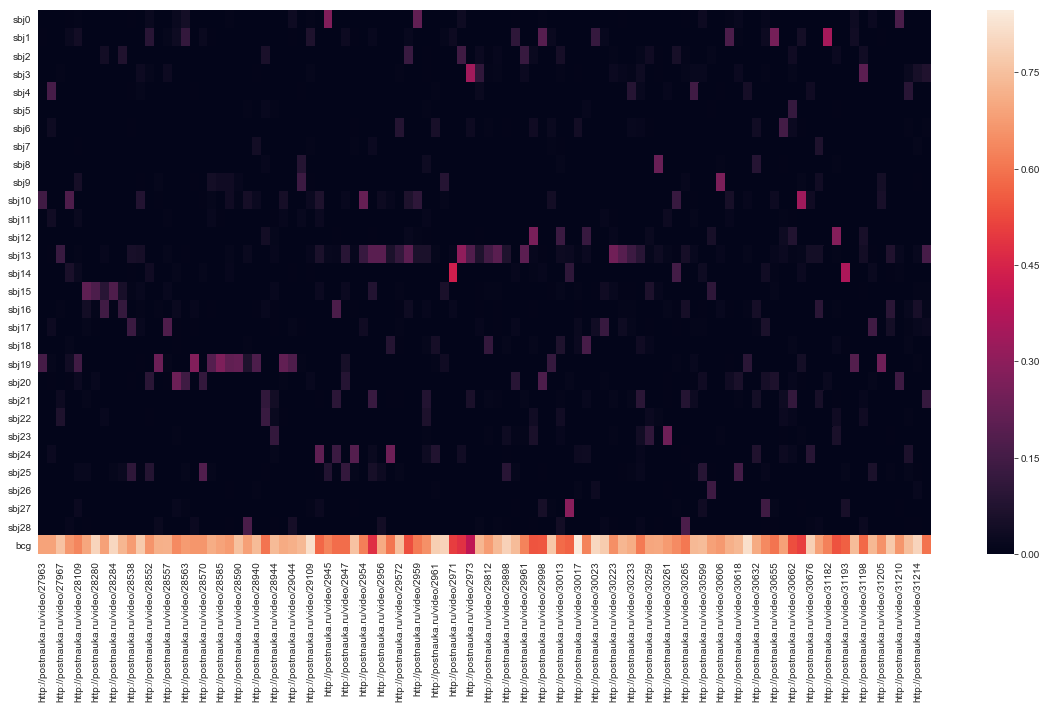

In [19]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta_topics_docs.iloc[:, :100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [20]:
# Ваш код
theta_topics_docs_sums = theta_topics_docs.sum(axis=1)
probs_topics_docs = pd.DataFrame(data=theta_topics_docs_sums/theta_topics_docs_sums.sum(), columns=["probs"])
probs_topics_docs

,probs
sbj0,0.009670
sbj1,0.014886
sbj2,0.009871
sbj3,0.006364
sbj4,0.006585
sbj5,0.006358
sbj6,0.007615
sbj7,0.004714
sbj8,0.008077
sbj9,0.010668


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [21]:
max_pt = probs_topics_docs.sort_values(by='probs')[-7:-2]
min_pt = probs_topics_docs.sort_values(by='probs')[:3]

In [20]:
print "5 тем с max p(t):"
for topic in max_pt.index:
    print topic_to_topic_labels.get(topic)

print
print "3 темы с min p(t):"
for topic in min_pt.index:
    print topic_to_topic_labels.get(topic)

5 тем с max p(t):
галактика планета
язык христианский
животное робот
энергия квантовый
клетка ген

3 темы с min p(t):
внимание костюм
трудность раса
память информация


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

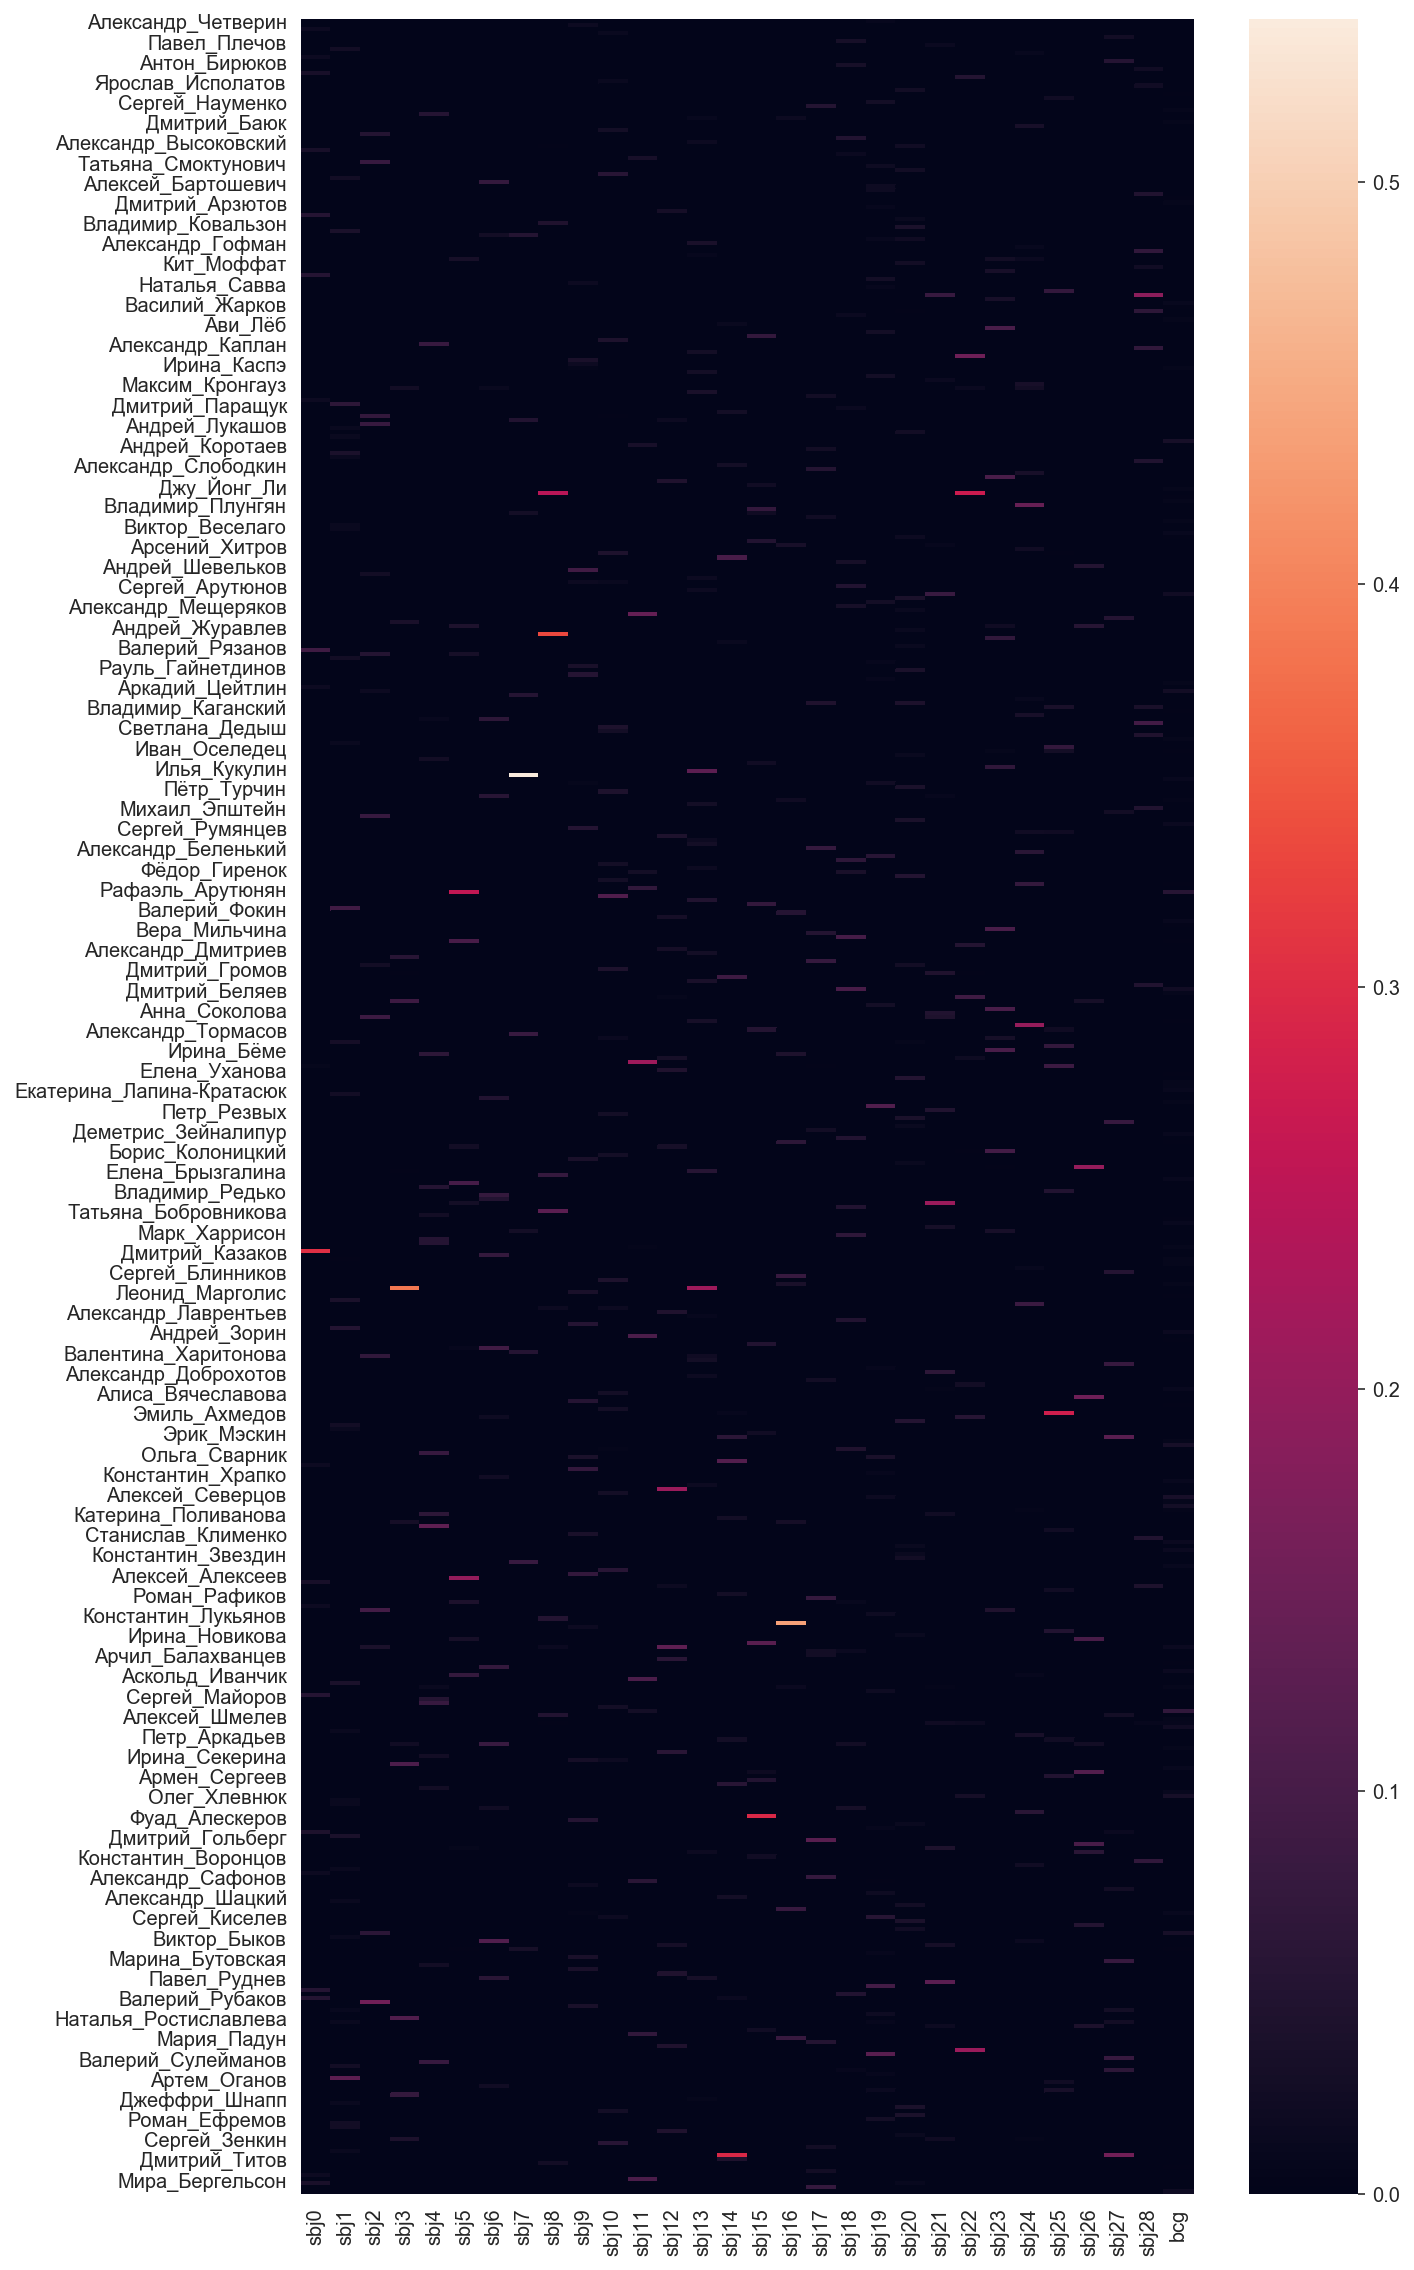

In [21]:
# Ваш код
plt.figure(figsize=(10, 20))
seaborn.heatmap(phi_authors_docs)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [22]:
print "авторы, значимые в не менее чем 3 темах:"
for author_name in phi_authors_docs.index:
    count = len(phi_authors_docs.loc[author_name][lambda prob: prob > 0.01])
    if count >= 3:
        print author_name, count

авторы, значимые в не менее чем 3 темах:
Олег_Ауров 3
Илья_Иткин 4
Андрей_Журавлев 3
Фёдор_Успенский 4
Ольга_Вайнштейн 3
Александр_Пиперски 4


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [23]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [24]:
# p(t) - probs_topics_docs
# p(a|t) - phi_authors_docs

In [25]:
# Ваш код
topic_profiles = phi_authors_docs.copy()
for author_name, probs in phi_authors_docs.iterrows():
    res = probs.values.reshape(30,1) * probs_topics_docs
    res = res/res.sum()
    topic_profiles.loc[author_name] = res.values.reshape(1, 30)

mds = MDS(dissimilarity="precomputed", random_state=321)
dissimilarity_matrix = pairwise_distances(X=topic_profiles, metric='cosine')
mds_transformed = mds.fit_transform(dissimilarity_matrix)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

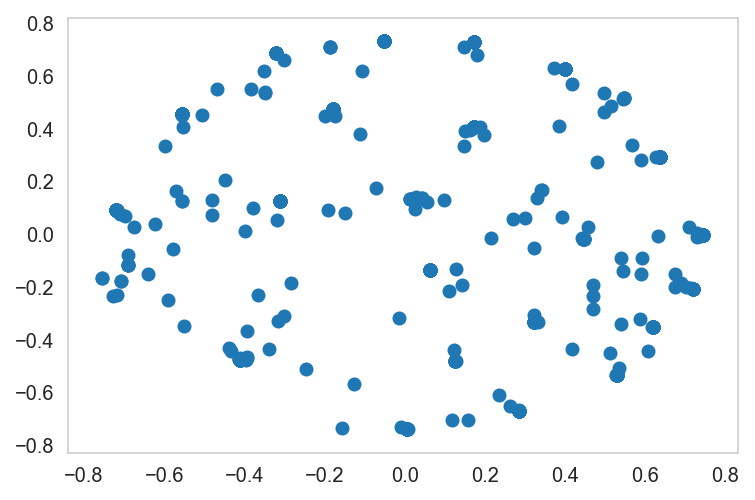

In [26]:
# Ваш код
plt.scatter(mds_transformed[:, 0], mds_transformed[:, 1])

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

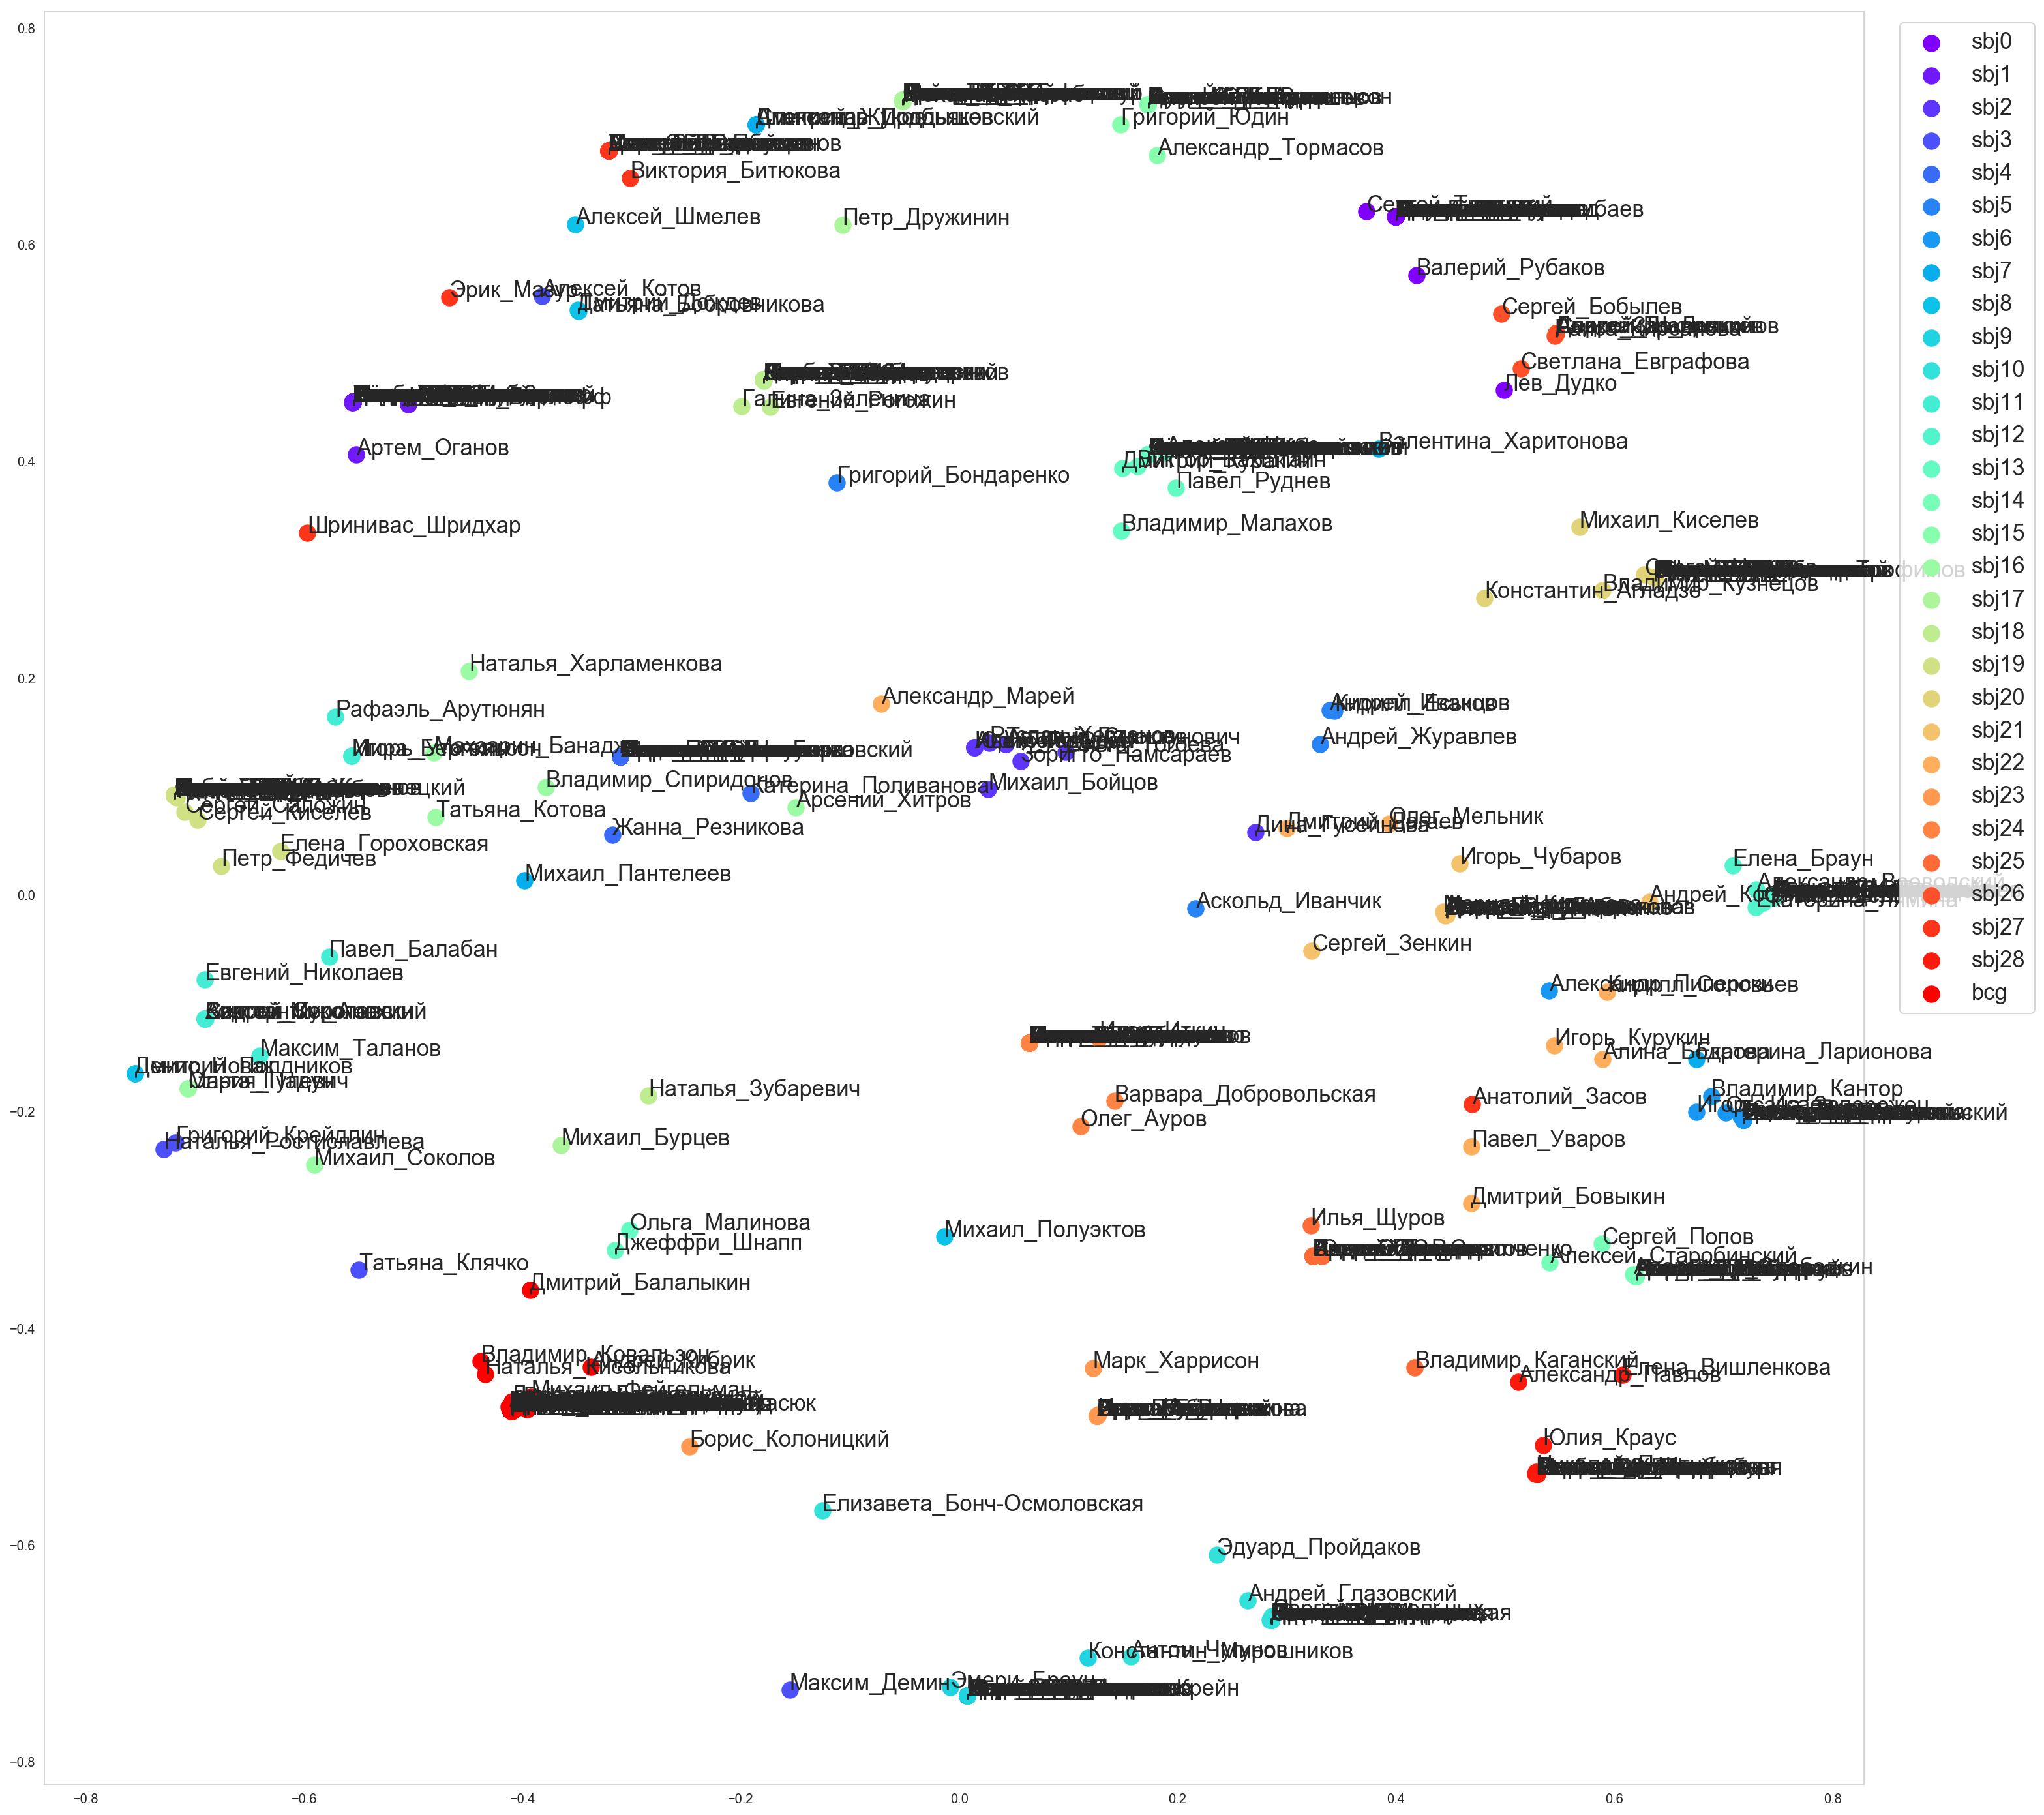

In [27]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
plt.figure(figsize=(25, 25))

max_topic_for_author = topic_profiles.idxmax(axis=1)
mds_transformed_df = pd.DataFrame(data=mds_transformed,index=topic_profiles.index)

for topic, color in zip(topic_names, colors):
    topic_author = mds_transformed_df[max_topic_for_author == topic]
    plt.scatter(topic_author.loc[:, 0],
                topic_author.loc[:, 1],
                c=color,
                label=topic,
                s=150)
    #i = 0
    for author_name, xy in topic_author.sort_values(by=1).iterrows():
        #i += 0.01
        #plt.annotate(s=author_name, xy=xy, xytext=(xy[0], xy[1]+i), fontsize='x-large')
        plt.annotate(s=author_name, xy=xy, fontsize='xx-large')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), fontsize='xx-large')
plt.savefig("PostnaukaPeerReview_topics_authors.pdf")

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [28]:
# Ваш код
topics_docs_probs = theta_topics_docs.copy()
for indx, row in topics_docs_probs.iterrows():
    topics_docs_probs.loc[indx] = row / row.sum()
    print topics_docs_probs.loc[indx].idxmax()

http://postnauka.ru/video/13043
http://postnauka.ru/video/31182
http://postnauka.ru/video/5517
http://postnauka.ru/video/2973
http://postnauka.ru/video/50793
http://postnauka.ru/video/43664
http://postnauka.ru/video/13156
http://postnauka.ru/video/31707
http://postnauka.ru/video/9299
http://postnauka.ru/video/13746
http://postnauka.ru/video/9861
http://postnauka.ru/video/9997
http://postnauka.ru/video/24034
http://postnauka.ru/video/10783
http://postnauka.ru/video/2971
http://postnauka.ru/video/53415
http://postnauka.ru/video/22892
http://postnauka.ru/video/32901
http://postnauka.ru/video/53171
http://postnauka.ru/video/5390
http://postnauka.ru/video/19457
http://postnauka.ru/video/2529
http://postnauka.ru/video/53577
http://postnauka.ru/video/34413
http://postnauka.ru/video/7755
http://postnauka.ru/video/3388
http://postnauka.ru/video/9389
http://postnauka.ru/video/53693
http://postnauka.ru/video/5396
http://postnauka.ru/video/51365


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [29]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [30]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [31]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

In [32]:
# Ваш код
for topic_label, label in topic_to_topic_labels.iteritems():
    display(HTML(u"<h2>{}</h2>".format(label)))
    if topic_label == 'bcg':
        indx = 29
    else:
        indx = int(topic_label.replace('sbj', ''))
    display(HTML(u"<div>{}</div>".format(" ".join(topic_to_words[indx][:10]))))
    links = topics_docs_probs.loc[topic_label].sort_values(ascending=False)[:10].index
    display(HTML(u"<ul>"))
    for link in links:
        display(HTML(u'<li><a href="{}" target="_blank">{}</a></li>'.format(link, link)))
    display(HTML(u"</ul>"))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 